<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStandard1/golds_Balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subclassing for GS

In [36]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import numpy as np

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Encode label values as numbers
    df['V10'] = df['V10'].replace({'negative': 0, 'positive': 1})
    
    # One-hot encode board space columns
    df = onehot_encode(
        df,
        columns=['V' + str(i) for i in range(1, 10)]
    )
    
    # Split df into X and y
    y = df['V10'].copy()
    X = df.drop('V10', axis=1).copy()
    
    # Train-test split
   # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X, y



def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(ook(y_true), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
        print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
        print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami




In [37]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1, neurons=4):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q
        self.neurons = neurons

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):

        def scheduler1(step = 10, ratio = 1.2):
          def scheduler(epoch, lr):
            if epoch % step == 0 and epoch>1:
              return lr/ratio
            else:
              return lr
          return scheduler
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        initializer = tf.keras.initializers.GlorotNormal(seed=100)

        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*self.neurons*(self.K+self.R)),activation='selu',name='h1',bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output', bias_initializer='zeros', kernel_initializer=initializer,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
               
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, callbacks = [callback1, callback2],   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
   
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q, 'neurons': self.neurons
                }

  
        return self


In [38]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-13 22:00:09--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 108.177.126.139, 108.177.126.138, 108.177.126.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/86ghg9ldbkg9bemcfmscudqmabn15miu/1676325600000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=f1795099-ea4c-4b9c-bf57-38d4ad35f0bd [following]
--2023-02-13 22:00:09--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/86ghg9ldbkg9bemcfmscudqmabn15miu/1676325600000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=f1795099-ea4c-4b9c-bf57-38d4ad35f0bd
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 108.177.126.

In [39]:
#cargar datos desde drive otros dataset
FILEID = "1AU8pTtCLihBjCZjWITaAzpnEuL4RO436"
#https://drive.google.com/file/d/1AU8pTtCLihBjCZjWITaAzpnEuL4RO436/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O  DataGCCE.zip && rm -rf /tmp/cookies.txt
!unzip -o DataGCCE.zip
!dir

--2023-02-13 22:00:14--  https://docs.google.com/uc?export=download&confirm=&id=1AU8pTtCLihBjCZjWITaAzpnEuL4RO436
Resolving docs.google.com (docs.google.com)... 108.177.126.139, 108.177.126.138, 108.177.126.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mlali28g6kol1jonev8gfn7a2tpk18dn/1676325600000/07591141114418430227/*/1AU8pTtCLihBjCZjWITaAzpnEuL4RO436?e=download&uuid=5c60cfa9-ff70-4f66-8d1a-7bf7afce67c2 [following]
--2023-02-13 22:00:14--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mlali28g6kol1jonev8gfn7a2tpk18dn/1676325600000/07591141114418430227/*/1AU8pTtCLihBjCZjWITaAzpnEuL4RO436?e=download&uuid=5c60cfa9-ff70-4f66-8d1a-7bf7afce67c2
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 108.177.126.1

# Load Data

In [40]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Balance' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv(r'/content/balance-scale.csv') 
df.head()

#Dividing X and y
t = np.array(LabelEncoder().fit_transform(df['Class'].tolist()))
X = np.array(df.drop(['Class'], axis = 1).values)
print('X',X.shape,'t',t.shape)
# t = t+1
# t
   

X (625, 4) t (625,)


In [41]:
t 

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0,
       2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1,
       2, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1,
       0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,

In [42]:
#t = t - 1

# Split data

In [43]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test  = X[train_index,:], X[test_index,:] 
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape,  Y_true_train.shape)

[618 454 423 593 338 404 345 132 150 379  54 386 508 378 242  43 602  11
 237 192 520  48 333 543 209 524  82 102 374 142 177 288 171 298 348 131
 384 246 470 566 138 353 421 491 320 604 474  85 367 477 527 567  57 548
 356 272 164 264 263 481 430 200 437   5 166  35 509 205 156 542 202 120
 243 107   9 620 601  78 560 134 422 574 282  59 328 512  31 199 185 568
 172 285 396 587 482 611 151 155 297 391  66 275 501 406 502 252 274 266
  75 582 383 327  13 600 300 227 310 431 397 162  79 529 335 221 294 614
 349 622 488 231 270 514 350  36 446 381 196 577 416 550  34  33 212 588
 347 118  15 230 159 429 398  93 217 181 556 190 403 116 336 456 452 170
 426 457 368 280  30   0  72 408 277 392 344 234 362  74 511  24 549 273
  64 402 268 226 261 575  55 287]
(437, 4) (437, 1)


# Apply MinMaxScaler

In [44]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


In [45]:
# from sklearn.metrics import classification_report, balanced_accuracy_score
# from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
# l1 =0.001
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# MI = np.zeros(NUM_RUNS)
# NMI = np.zeros(NUM_RUNS)
# AMI = np.zeros(NUM_RUNS)
# BACC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
   
#     MA = Keras_MA_GCCE(epochs=100,batch_size=256,R=5, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.01,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)

    
#     MA.fit(X_train,  Y_true_train)
#     MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
#     ACC[i] = report['accuracy']
#     print("Validation ACC: %.4f" % (float(ACC[i])))


#     # balanced. Accurcy
#     BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
#     print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

#     #MI
    
#     MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation MI: %.4f" % (float(MI[i]),))
#     NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
#     AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
#    # val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    

iteration: 0


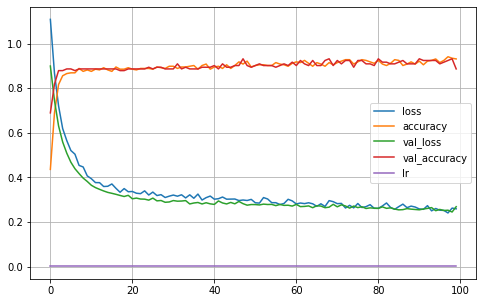

6/6 [==============================] - 0s 3ms/step
iteration: 1


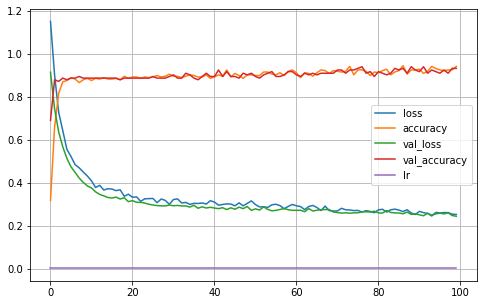

6/6 [==============================] - 0s 3ms/step
iteration: 2


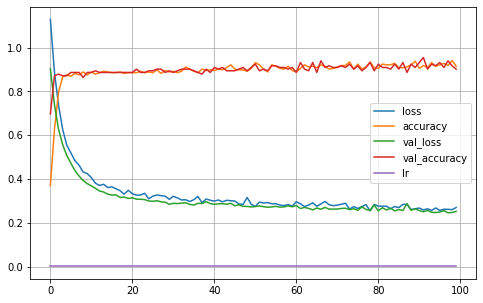

6/6 [==============================] - 0s 3ms/step
iteration: 3


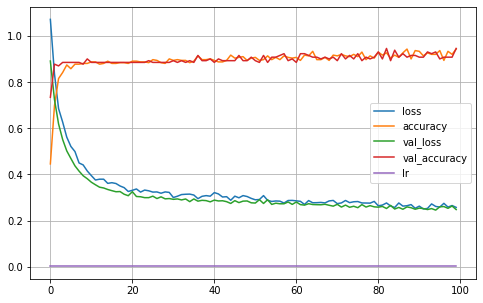

6/6 [==============================] - 0s 3ms/step
iteration: 4


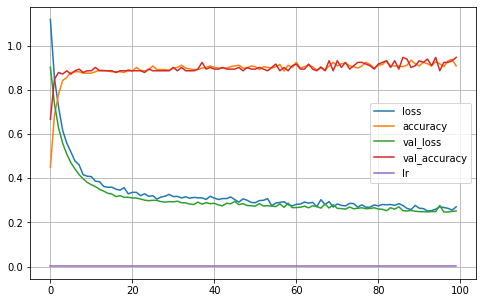

6/6 [==============================] - 0s 3ms/step
iteration: 5


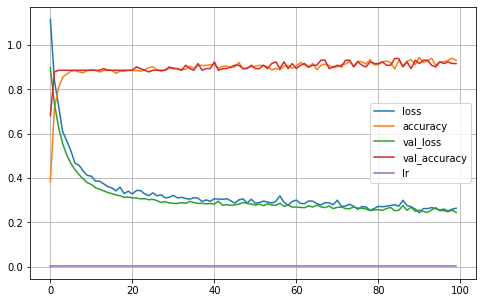

6/6 [==============================] - 0s 3ms/step
iteration: 6


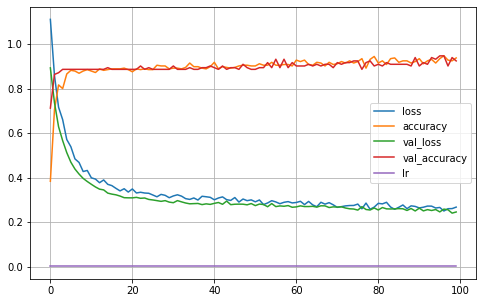

6/6 [==============================] - 0s 4ms/step
iteration: 7


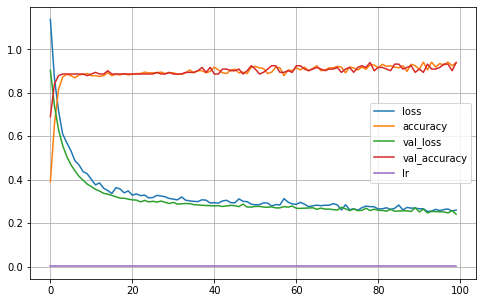

6/6 [==============================] - 0s 4ms/step
iteration: 8


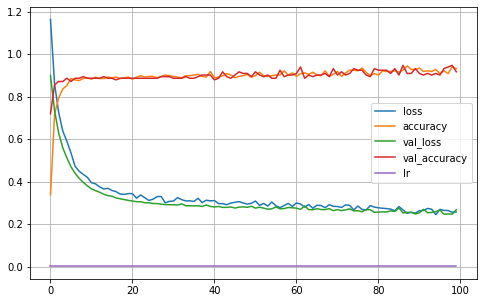

6/6 [==============================] - 0s 2ms/step
iteration: 9


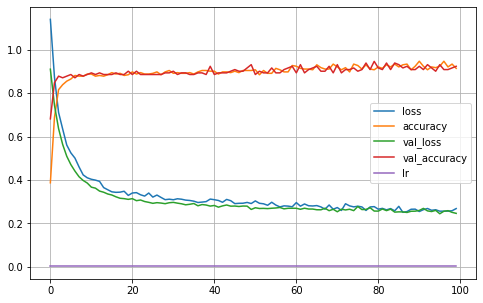

6/6 [==============================] - 0s 3ms/step


In [46]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import pandas as pd
l1 =   0.0001
NUM_RUNS =10
custom_loss = "GOLD"


results = []
for i in range(NUM_RUNS):

    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=32,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)



    MA.fit(X_train, Y_true_train)
    MA.plot_history()
  
    # Generate the predictions for the current run
    pred_2 = MA.predict(X_test)
     
    acc, auc, auc_sk,  nmi,  bacc = evaluation_metrics(Y_true_test,  pred_2, print_result=False)  # mi, ami,
    
    # Save the results for the current run to the list of dictionaries
    results.append({
        #'run': i,
        'accuracy': acc,
        'balanced_accuracy': bacc,
       # 'mutual_information': mi,
        'normalized_mutual_information': nmi,
     #   'adjusted_mutual_information': ami,
        'auc_tensorflow': auc,
        'auc_scikit_learn': auc_sk,
    })
    
# Convert the list of dictionaries to a DataFrame
df = np.round(pd.DataFrame(results)*100, 2)

# Calculate the mean and standard deviation of each metric
mean = np.round(df.mean(),2)
std = np.round(df.std(),2)  


In [47]:
df

,accuracy,balanced_accuracy,normalized_mutual_information,auc_tensorflow,auc_scikit_learn
0,86.17,46.81,65.35,73.180000,97.92
1,89.89,64.57,72.17,81.910004,98.47
2,87.23,50.69,69.37,74.639999,98.24
3,94.15,74.42,76.98,84.800003,98.84
4,91.49,66.20,73.40,83.580002,98.54
5,90.43,65.11,72.90,82.370003,98.36
6,89.36,61.23,71.77,80.150002,98.40
7,92.02,75.03,73.30,87.690002,98.81
8,89.36,58.44,69.59,79.480003,98.28
9,90.43,65.03,71.27,82.540001,98.67


In [53]:
mean

accuracy                         90.05
balanced_accuracy                62.75
normalized_mutual_information    71.61
auc_tensorflow                   81.03
auc_scikit_learn                 98.45
dtype: float64

In [54]:
std

accuracy                         2.29
balanced_accuracy                9.03
normalized_mutual_information    3.08
auc_tensorflow                   4.42
auc_scikit_learn                 0.28
dtype: float64

In [55]:
result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

In [56]:
result_df

,Mean,Std
accuracy,90.05,2.29
balanced_accuracy,62.75,9.03
normalized_mutual_information,71.61,3.08
auc_tensorflow,81.03,4.42
auc_scikit_learn,98.45,0.28


In [57]:
# Save the DataFrame to an excel file
result_df.to_excel(database + custom_loss + ".xlsx")